# **Detection and segmentation of robot hands and objects selected for picking**

Muraleekrishna Harikumar Sreeja | Student Number: 210696370 | m.harikumarsreeja@se21.qmul.ac.uk

Project Supervisor: Lorenzo Jamone | MSc. Artificial Intelligence, QMUL


In [2]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 8.7 MB/s 


In [3]:
!pip install tensorflow==1.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 39 kB/s 
     |████████████████████████████████| 488 kB 48.6 MB/s 
     |████████████████████████████████| 3.1 MB 43.4 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
ERROR: pip's dependency resolver does not currently ta

In [4]:
!pip install keras==2.0.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 6.6 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [5]:
!pip install 'h5py==2.10.0' --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 8.1 MB/s 
     |████████████████████████████████| 15.7 MB 55.1 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.14.0 which is incompatible.


In [6]:
!pip install xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# Importing dependencies

import os 
import sys
import cv2
import json
import glob
import math
import gdown
import random
import pydicom
import xmltodict
import numpy as np
import skimage.draw
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

import warnings
warnings.simplefilter(action='ignore')

In [8]:
# Get Mask_RCNN library from github

!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
root_folder = '/content'

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 24.09 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [9]:
# Import the dependencies of Mask_RCNN

sys.path.append(os.path.join(root_folder, 'Mask_RCNN'))
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [10]:
# Mount Google drive 

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [11]:
# Set path of the dataset
dataset_path = os.path.join('/content/drive/MyDrive/Final_Project', 'Dataset')

In [12]:
# Detector configuration class 
# The settings were chosen to reduce the running time.

class Configuration(Config):
    
    NAME = 'grocery'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    BACKBONE = 'resnet50'
    NUM_CLASSES = 8 
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    STEPS_PER_EPOCH = 25
    
config = Configuration()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [13]:
# Dataset class for training our dataset

class Dataset_Detection(utils.Dataset):

    def load_labels(self, labels_list):
        for i, label in enumerate(labels_list):
            self.add_class('grocery', i + 1, label)
            
    def load_dataset(self, images_obj):
        for image_obj in images_obj:
            image_id = image_obj['image_id']
            dataset_path = image_obj['dataset_path']
            num_ids = image_obj['num_ids']
            polygons = image_obj['polygons']
            width = image_obj['width']
            height = image_obj['height']
            self.add_image("grocery", image_id=image_id, path=dataset_path, width=width, height=height, polygons=polygons,num_ids=num_ids)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],dtype=np.uint8)

        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def draw_shape(self, image, shape, dims, color):
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image



In [14]:
# Define the labels

labels = ["robot hand","avocado single", "banana single", "blueberry single","avocado clutter", "banana clutter", "blueberry clutter"]

In [15]:
# Parse single annotation

def single_annotation_parse(label_obj):
    name = label_obj['name']
    num_id = labels.index(name) + 1
    bb_box = label_obj['bndbox']
    xmin = int(bb_box['xmin'])
    xmax = int(bb_box['xmax'])
    ymin = int(bb_box['ymin'])
    ymax = int(bb_box['ymax'])
    all_points_x = [xmin, xmax, xmax, xmin, xmin]
    all_points_y = [ymin, ymin, ymax, ymax, ymin]
    return all_points_x, all_points_y, num_id

In [16]:
# Parse the images and annotations into a single array.

train_images = []

def annot_transform(dataset_path):
    start_idx = 100
    img_list = []
    for i in os.listdir(os.path.join(dataset_path)):
        img_path = os.path.join(dataset_path, i)
        split_img_path = i.split('.')
        if split_img_path[1] == 'jpg':
            polygons = []
            num_ids = [] 
            file_data = cv2.imread(img_path)
            height, width, _ = file_data.shape
            with open(os.path.join(dataset_path, split_img_path[0] + '.xml')) as fd:
                bb_file = json.loads(json.dumps(xmltodict.parse(fd.read())))
                if isinstance(bb_file['annotation']['object'], list):
                    for obj in bb_file['annotation']['object']:
                        all_points_x, all_points_y, num_id = single_annotation_parse(obj)
                        polygons.append({
                            'all_points_x': all_points_x,
                            'all_points_y': all_points_y
                        })
                        num_ids.append(num_id)
                else:
                    all_points_x, all_points_y, num_id = single_annotation_parse(bb_file['annotation']['object'])
                    polygons.append({
                        'all_points_x': all_points_x,
                        'all_points_y': all_points_y
                    })
                    num_ids.append(num_id)
            img_label = {
                'dataset_path': img_path,
                'image_id': start_idx,
                'polygons': polygons,
                'num_ids': num_ids,
                'height': height,
                'width': width
            }
            start_idx = start_idx + 1
            img_list.append(img_label)
    return img_list

In [17]:
# Load and prepare the training data

train_data = annot_transform(os.path.join(dataset_path, 'train'))
print(train_data[0:5])
train_dataset = Dataset_Detection()
train_dataset.load_labels(labels)
train_dataset.load_dataset(train_data)
train_dataset.prepare()

[{'dataset_path': '/content/drive/MyDrive/Final_Project/Dataset/train/banana_single_16569.jpg', 'image_id': 100, 'polygons': [{'all_points_x': [440, 744, 744, 440, 440], 'all_points_y': [323, 323, 553, 553, 323]}, {'all_points_x': [970, 1430, 1430, 970, 970], 'all_points_y': [201, 201, 573, 573, 201]}], 'num_ids': [3, 1], 'height': 1080, 'width': 1920}, {'dataset_path': '/content/drive/MyDrive/Final_Project/Dataset/train/banana_single_17211.jpg', 'image_id': 101, 'polygons': [{'all_points_x': [440, 716, 716, 440, 440], 'all_points_y': [325, 325, 537, 537, 325]}, {'all_points_x': [356, 722, 722, 356, 356], 'all_points_y': [49, 49, 501, 501, 49]}], 'num_ids': [3, 1], 'height': 1080, 'width': 1920}, {'dataset_path': '/content/drive/MyDrive/Final_Project/Dataset/train/banana_single_18486.jpg', 'image_id': 102, 'polygons': [{'all_points_x': [946, 1202, 1202, 946, 946], 'all_points_y': [281, 281, 617, 617, 281]}, {'all_points_x': [930, 1388, 1388, 930, 930], 'all_points_y': [73, 73, 541, 541

In [18]:
# Load and prepare the test data

test_data = annot_transform(os.path.join(dataset_path, 'test'))
test_dataset = Dataset_Detection()
test_dataset.load_labels(labels)
test_dataset.load_dataset(test_data)
test_dataset.prepare()

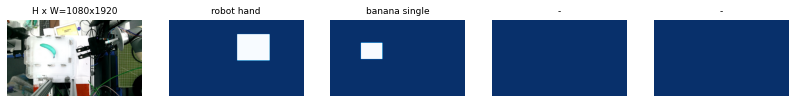

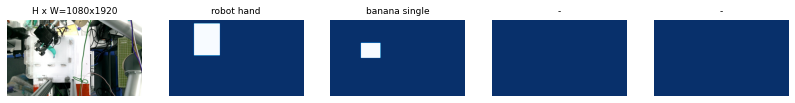

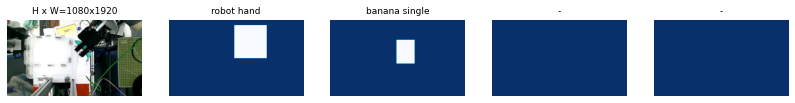

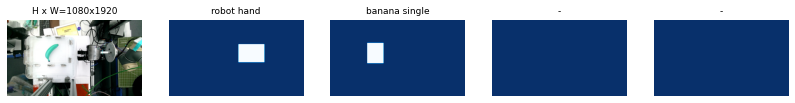

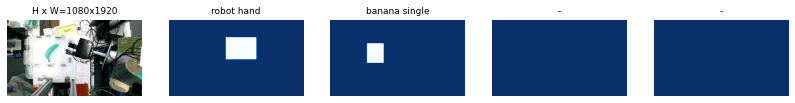

In [19]:
#Load and display the pixel mask for initial 10 items.

for i in range(5):
    image_id = train_data[i]['image_id']
    mask, num_id = train_dataset.load_mask(i)
    img_data = cv2.imread(train_data[i]['dataset_path'])
    num_id = [x - 1 for x in num_id]
    visualize.display_top_masks(img_data, mask, num_id, labels)

In [20]:
# Download coco weights

sys.path.append(root_folder)
model_folder = os.path.join(root_folder, 'logs')
coco_model_dir = os.path.join(root_folder, "mask_rcnn_coco.h5")
if not os.path.exists(coco_model_dir):
    utils.download_trained_weights(coco_model_dir)

... done downloading pretrained model!


In [21]:
# Create the model in training mode with the specified configuration
# Ignore the warnings for the ttime being

model = modellib.MaskRCNN(mode="training", config=config,model_dir=model_folder)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [22]:
# Load the coco weights

model.load_weights(coco_model_dir, by_name=True,exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

In [23]:
#Lets Train the dataset 
#Initially train heads with higher learning rate to speedup learning

%%time
model.train(train_dataset, test_dataset,
            learning_rate=config.LEARNING_RATE*2, 
            epochs=2,
            layers='heads')

history = model.keras_model.history.history


Starting at epoch 0. LR=0.002

Checkpoint Path: /content/logs/grocery20220813T0707/mask_rcnn_grocery_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4       


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




Epoch 1/2
25/25 [==============================] - 1877s - loss: 2.3837 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.4229 - mrcnn_class_loss: 0.6504 - mrcnn_bbox_loss: 0.6208 - mrcnn_mask_loss: 0.6483 - val_loss: 1.6417 - val_rpn_class_loss: 0.0321 - val_rpn_bbox_loss: 0.3758 - val_mrcnn_class_loss: 0.3254 - val_mrcnn_bbox_loss: 0.3988 - val_mrcnn_mask_loss: 0.5096
Epoch 2/2
25/25 [==============================] - 1734s - loss: 1.2675 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.3011 - mrcnn_class_loss: 0.1932 - mrcnn_bbox_loss: 0.3353 - mrcnn_mask_loss: 0.4131 - val_loss: 1.1855 - val_rpn_class_loss: 0.0222 - val_rpn_bbox_loss: 0.3370 - val_mrcnn_class_loss: 0.1784 - val_mrcnn_bbox_loss: 0.3005 - val_mrcnn_mask_loss: 0.3474
CPU times: user 1h 26min 19s, sys: 1min 31s, total: 1h 27min 50s
Wall time: 1h 21s


In [24]:
# Now lets train using all the layers

%%time
model.train(train_dataset, test_dataset,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='all')

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=0.001

Checkpoint Path: /content/logs/grocery20220813T0707/mask_rcnn_grocery_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b        

In [25]:
#Epoch history

epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.641665,0.032060,0.375779,0.325417,0.398762,0.509647,2.383713,0.041374,0.422855,0.650369,0.620849,0.648265
2,1.185545,0.022157,0.337046,0.178374,0.300537,0.347429,1.267500,0.024833,0.301117,0.193188,0.335265,0.413096
3,0.978095,0.017845,0.283553,0.144429,0.235415,0.296846,0.959075,0.019752,0.257372,0.131084,0.228995,0.321865
4,0.904248,0.013974,0.247032,0.129200,0.215154,0.298880,0.879707,0.014873,0.227141,0.123326,0.205437,0.308923
5,0.894507,0.011858,0.252499,0.118519,0.213679,0.297945,0.745218,0.010945,0.182663,0.089314,0.172847,0.289442
6,0.845779,0.012340,0.262450,0.109451,0.182270,0.279261,0.739786,0.009273,0.197760,0.076333,0.170724,0.285689
7,0.819951,0.010210,0.238897,0.111513,0.181762,0.277563,0.661282,0.008576,0.148282,0.072648,0.164781,0.266989
8,0.755521,0.009555,0.210542,0.104238,0.170554,0.260625,0.621127,0.007436,0.134164,0.072716,0.148323,0.258482
9,0.731458,0.008050,0.213041,0.089343,0.163410,0.257606,0.566288,0.006249,0.112490,0.063366,0.130726,0.253451
10,0.700497,0.008346,0.204667,0.081800,0.158295,0.247383,0.527187,0.005318,0.100711,0.057817,0.120899,0.242435


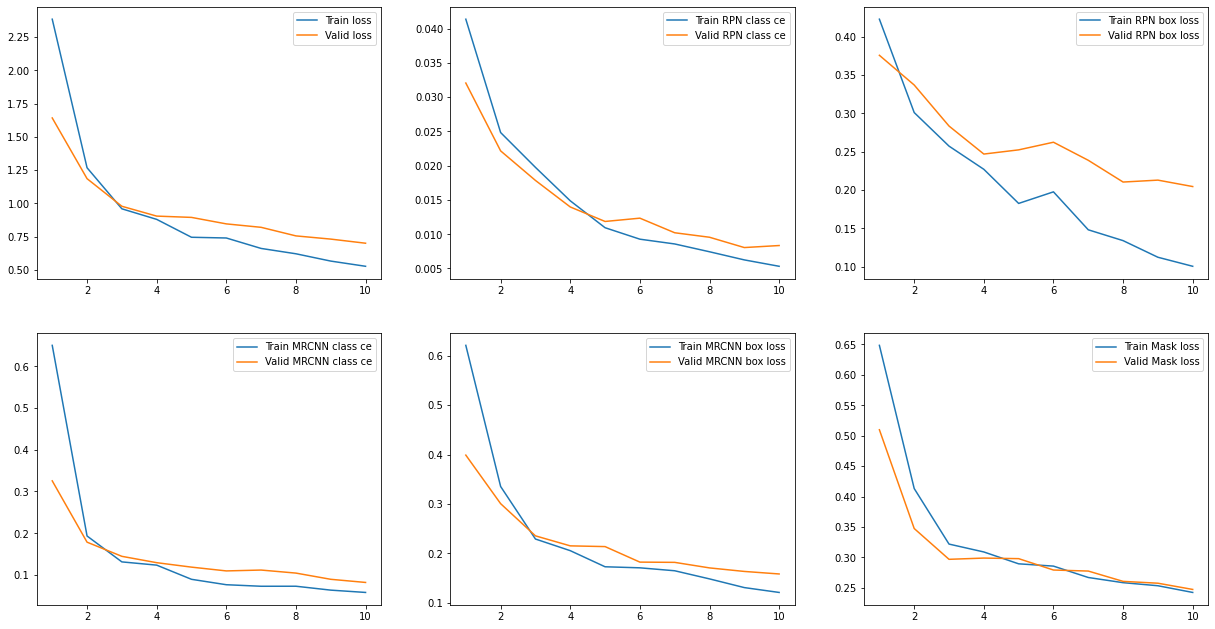

In [26]:
#Loss Analysis

plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()

In [27]:
#Find the best epoch and val_loss

best_epoch = np.argmin(history["val_loss"])
score = history["val_loss"][best_epoch]
print(f'Best Epoch so far:{best_epoch+1} val_loss:{score}')

Best Epoch so far:10 val_loss:0.7004969835281372


In [28]:
os.listdir(model_folder)

['grocery20220813T0707']

In [29]:
dir_names = os.listdir(model_folder)
dir_names = sorted(dir_names)

fps = []
for d in dir_names: 
    dir_name = os.path.join(model_folder, d)
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model location at {}'.format(model_path))

Found model location at /content/logs/grocery20220813T0707/mask_rcnn_grocery_0009.h5


In [30]:
# Class for Inference configuration

class Config_Inference(Configuration):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = Config_Inference()
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=root_folder)
assert model_path != "", "Provide the path to the trained weights"
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.


Re-starting from epoch 9


In [31]:
#Set colour for the class ids

def set_colour(class_ids):
    class_ids = [x - 1 for x in class_ids]
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

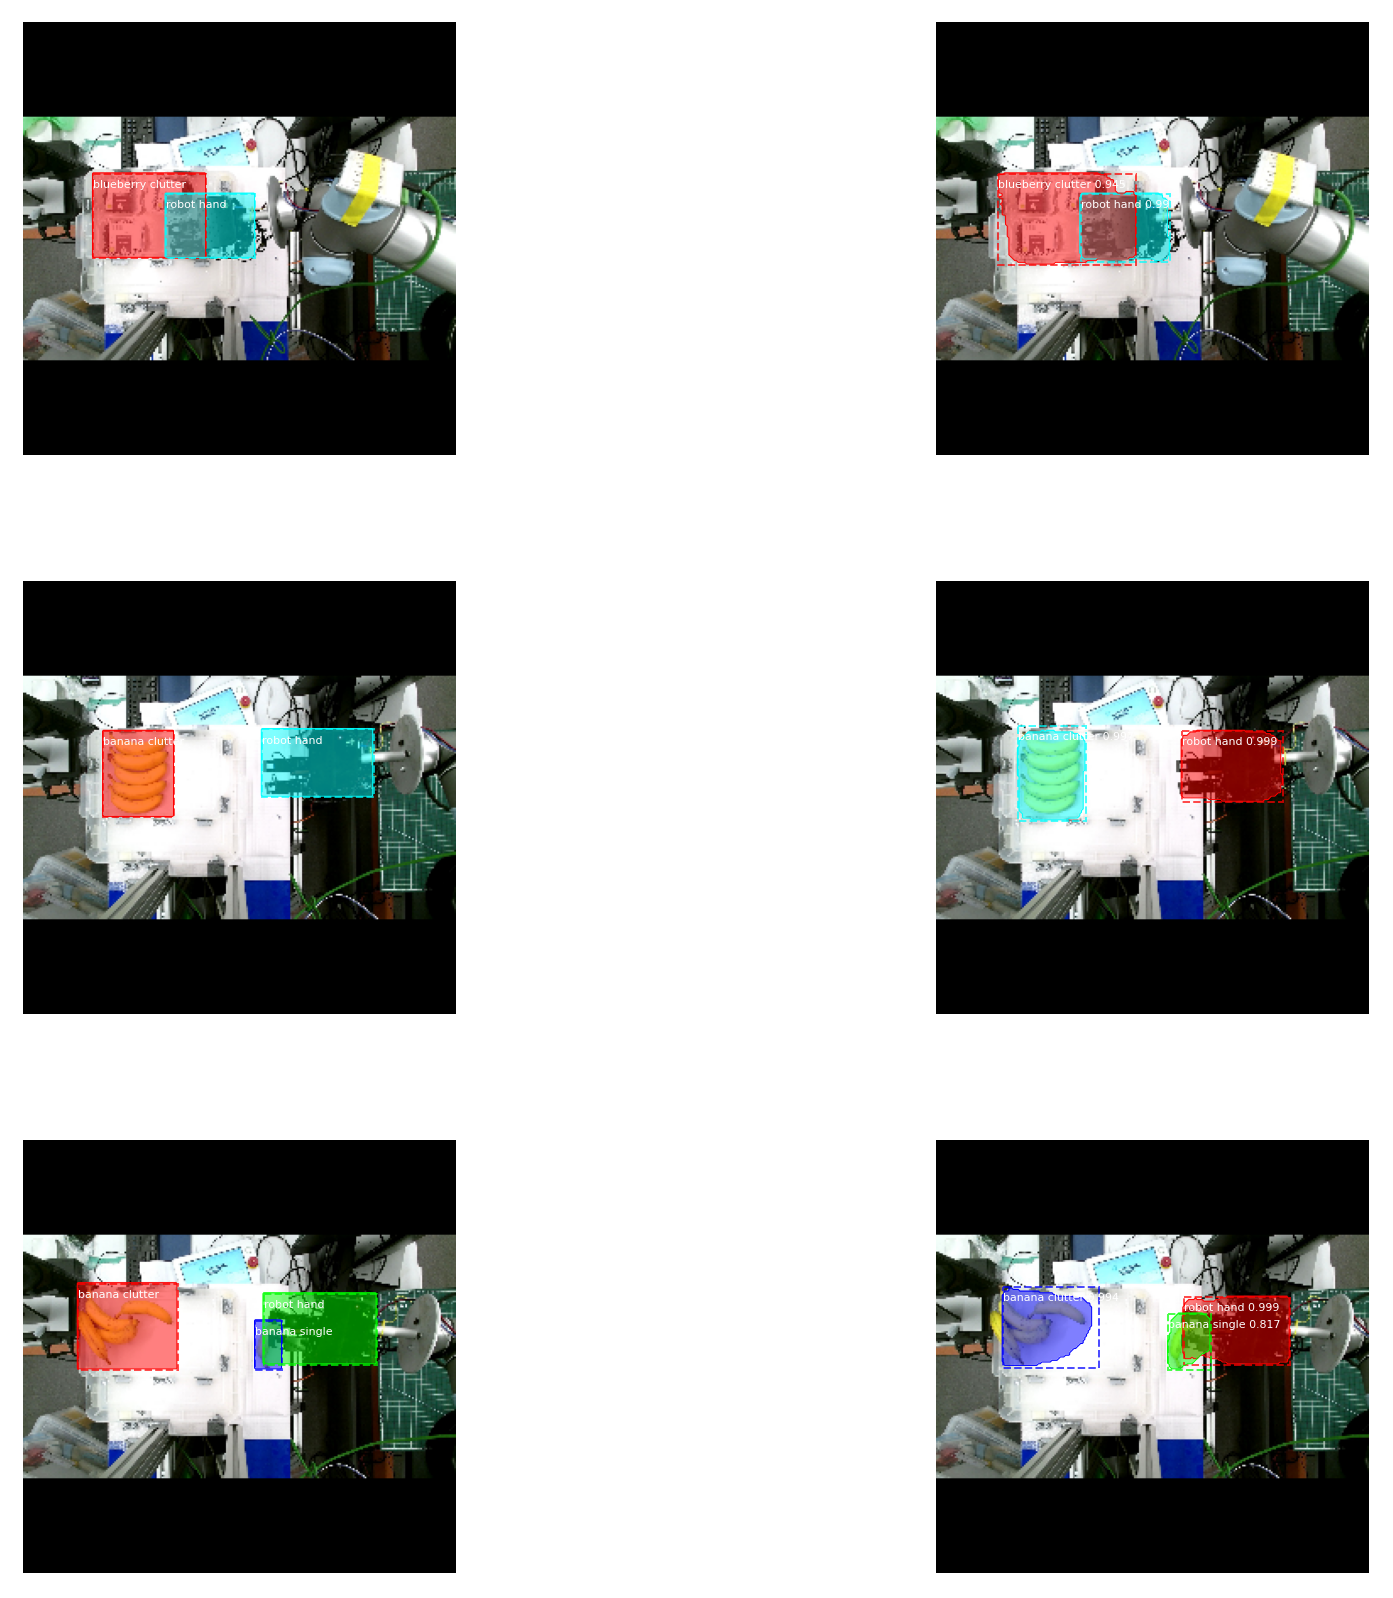

In [41]:
#Generate Output

dataset = test_dataset
fig = plt.figure(figsize=(30, 60))
start_idx = 0
for i in range(start_idx, start_idx + 3):
    
    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(test_dataset, inference_config, 
                               image_id, use_mini_mask=False)
    plt.subplot(6, 2, 2*(i-start_idx) + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=set_colour(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*(i-start_idx) + 2)
    results = model.detect([original_image])
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=set_colour(r['class_ids']), ax=fig.axes[-1])